In [31]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
combined = pd.read_csv('../exps/feature_Labels/combined_Onehot.csv')

In [33]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,FamilySize,Singleton,SmallFamily,LargeFamily
0,3,0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2,0,1,0
1,1,1,38.0,1,0,71.2833,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,0
2,3,1,26.0,0,0,7.9250,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0,0
3,1,1,35.0,1,0,53.1000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,0
4,3,0,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0,0


In [34]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring) #sẽ được huấn luyện 5 lần trên 4 phần, và được đánh giá trên 1 phần còn lại.
    return np.mean(xval)

# Tách dữ liệu train và test

In [35]:
def recover_train_test_target():
    # 1. Tách cột mục tiêu (Target)
    targets = pd.read_csv('../data/train.csv',usecols=['Survived'])['Survived'].values
    # 2. Loại bỏ cột mục tiêu khỏi tập train
    train = combined.iloc[:891]
    # 3. Tập test được giữ nguyên (giả sử nó không có cột 'Survived')
    test = combined.iloc[891:]
    
    return train, test, targets

In [36]:
train,test,targets = recover_train_test_target()

## Chọn lọc đặc trưng quan trọng
- vì ta có 29 đặc trưng khác nhau đây là một con số khá lớn vì thế ta sẽ chọn ra các đặc trưng quan trọng
- Khi feature engineering hoàn tất, chúng ta thường có xu hướng giảm số chiều bằng cách chọn ra số lượng đặc trưng "phù hợp" nhất để nắm bắt được những thông tin cốt lõi.
- Trên thực tế, chọn lọc đặc trưng (feature selection) mang lại nhiều lợi ích:
    + Nó làm giảm sự dư thừa giữa các dữ liệu.
    + Nó tăng tốc độ của quá trình huấn luyện mô hình.    
    + Nó giúp giảm thiểu hiện tượng quá khớp.

In [37]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

In [38]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

<Axes: ylabel='feature'>

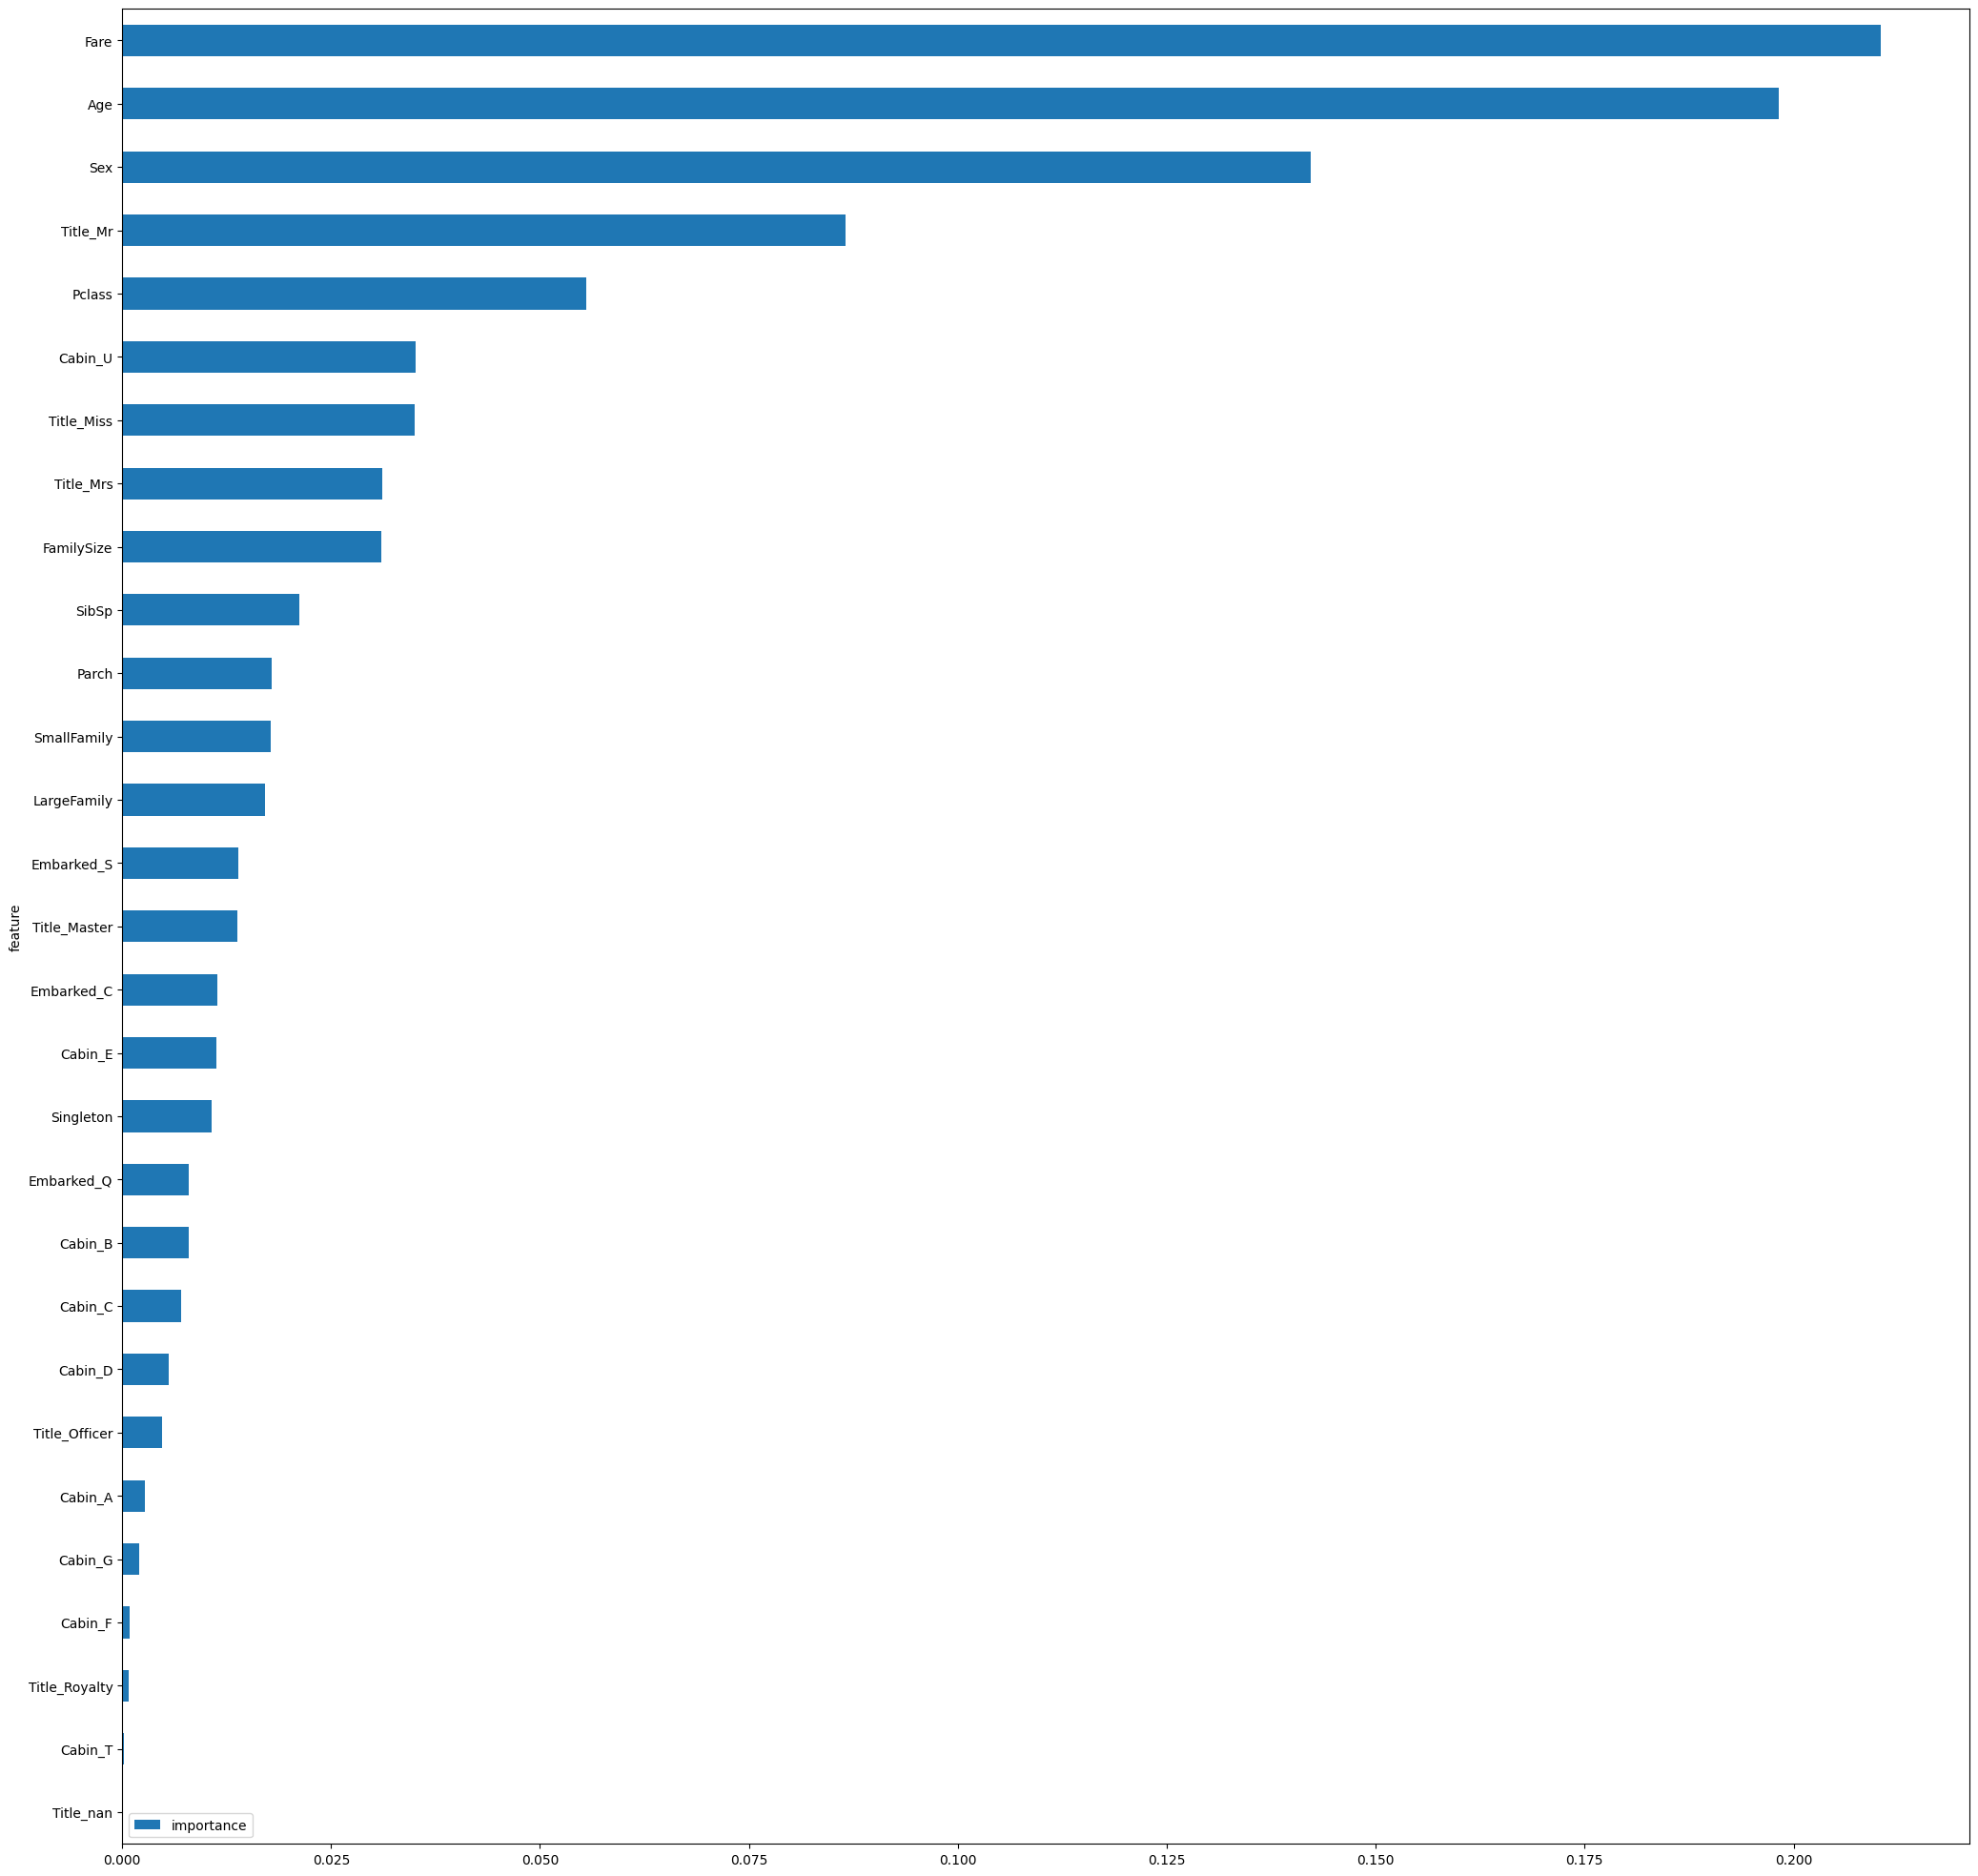

In [39]:
features.plot(kind='barh', figsize=(25, 25))

Theo sơ đồ có thể thấy, một số đặc trưng quan trọng như Title_Mr, Age, Fare, and Sex.

In [40]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
print(train_reduced.shape)

(891, 7)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [41]:
test_reduced = model.transform(test)
print(test_reduced.shape)

(418, 7)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## Base Models

In [42]:
log = LogisticRegression(max_iter=5000,random_state=42)
log_cv = LogisticRegressionCV(cv=5,max_iter=5000,random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

models = [log,log_cv,rf,gb]

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [43]:
for model in models:
    print('Cross-validation of: {0}'.format(model))
    score = cross_val_score(model,train_reduced,targets,cv=k_fold,n_jobs=1,scoring='accuracy')
    print("Score of Model:",round(np.mean(score)*100,2))

Cross-validation of: LogisticRegression(max_iter=5000, random_state=42)
Score of Model: 79.8
Cross-validation of: LogisticRegressionCV(cv=5, max_iter=5000, random_state=42)
Score of Model: 79.13
Cross-validation of: RandomForestClassifier(random_state=42)
Score of Model: 81.93
Cross-validation of: GradientBoostingClassifier(random_state=42)
Score of Model: 81.48


In [44]:
clf1 = LogisticRegression(max_iter=5000,random_state=42)
clf1.fit(train_reduced,targets)
prediction = clf1.predict(test_reduced)

In [45]:
test_data = pd.read_csv('../data/test.csv')

In [46]:
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'], 
    'Survived': prediction
})
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv("../Submit/Submission.csv",index=False,header=True)

In [47]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier

In [48]:
combined = pd.read_csv('../exps/feature_Labels/combined_Onehot.csv')

In [49]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,FamilySize,Singleton,SmallFamily,LargeFamily
0,3,0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2,0,1,0
1,1,1,38.0,1,0,71.2833,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,0
2,3,1,26.0,0,0,7.9250,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0,0
3,1,1,35.0,1,0,53.1000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,0
4,3,0,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0,0


In [50]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring) #sẽ được huấn luyện 5 lần trên 4 phần, và được đánh giá trên 1 phần còn lại.
    return np.mean(xval)

# Tách dữ liệu train và test

In [51]:
def recover_train_test_target():
    # 1. Tách cột mục tiêu (Target)
    targets = pd.read_csv('../data/train.csv',usecols=['Survived'])['Survived'].values
    # 2. Loại bỏ cột mục tiêu khỏi tập train
    train = combined.iloc[:891]
    # 3. Tập test được giữ nguyên (giả sử nó không có cột 'Survived')
    test = combined.iloc[891:]
    
    return train, test, targets

In [52]:
train,test,targets = recover_train_test_target()

## Chọn lọc đặc trưng quan trọng
- vì ta có 29 đặc trưng khác nhau đây là một con số khá lớn vì thế ta sẽ chọn ra các đặc trưng quan trọng
- Khi feature engineering hoàn tất, chúng ta thường có xu hướng giảm số chiều bằng cách chọn ra số lượng đặc trưng "phù hợp" nhất để nắm bắt được những thông tin cốt lõi.
- Trên thực tế, chọn lọc đặc trưng (feature selection) mang lại nhiều lợi ích:
    + Nó làm giảm sự dư thừa giữa các dữ liệu.
    + Nó tăng tốc độ của quá trình huấn luyện mô hình.    
    + Nó giúp giảm thiểu hiện tượng quá khớp.

In [53]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

In [54]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

<Axes: ylabel='feature'>

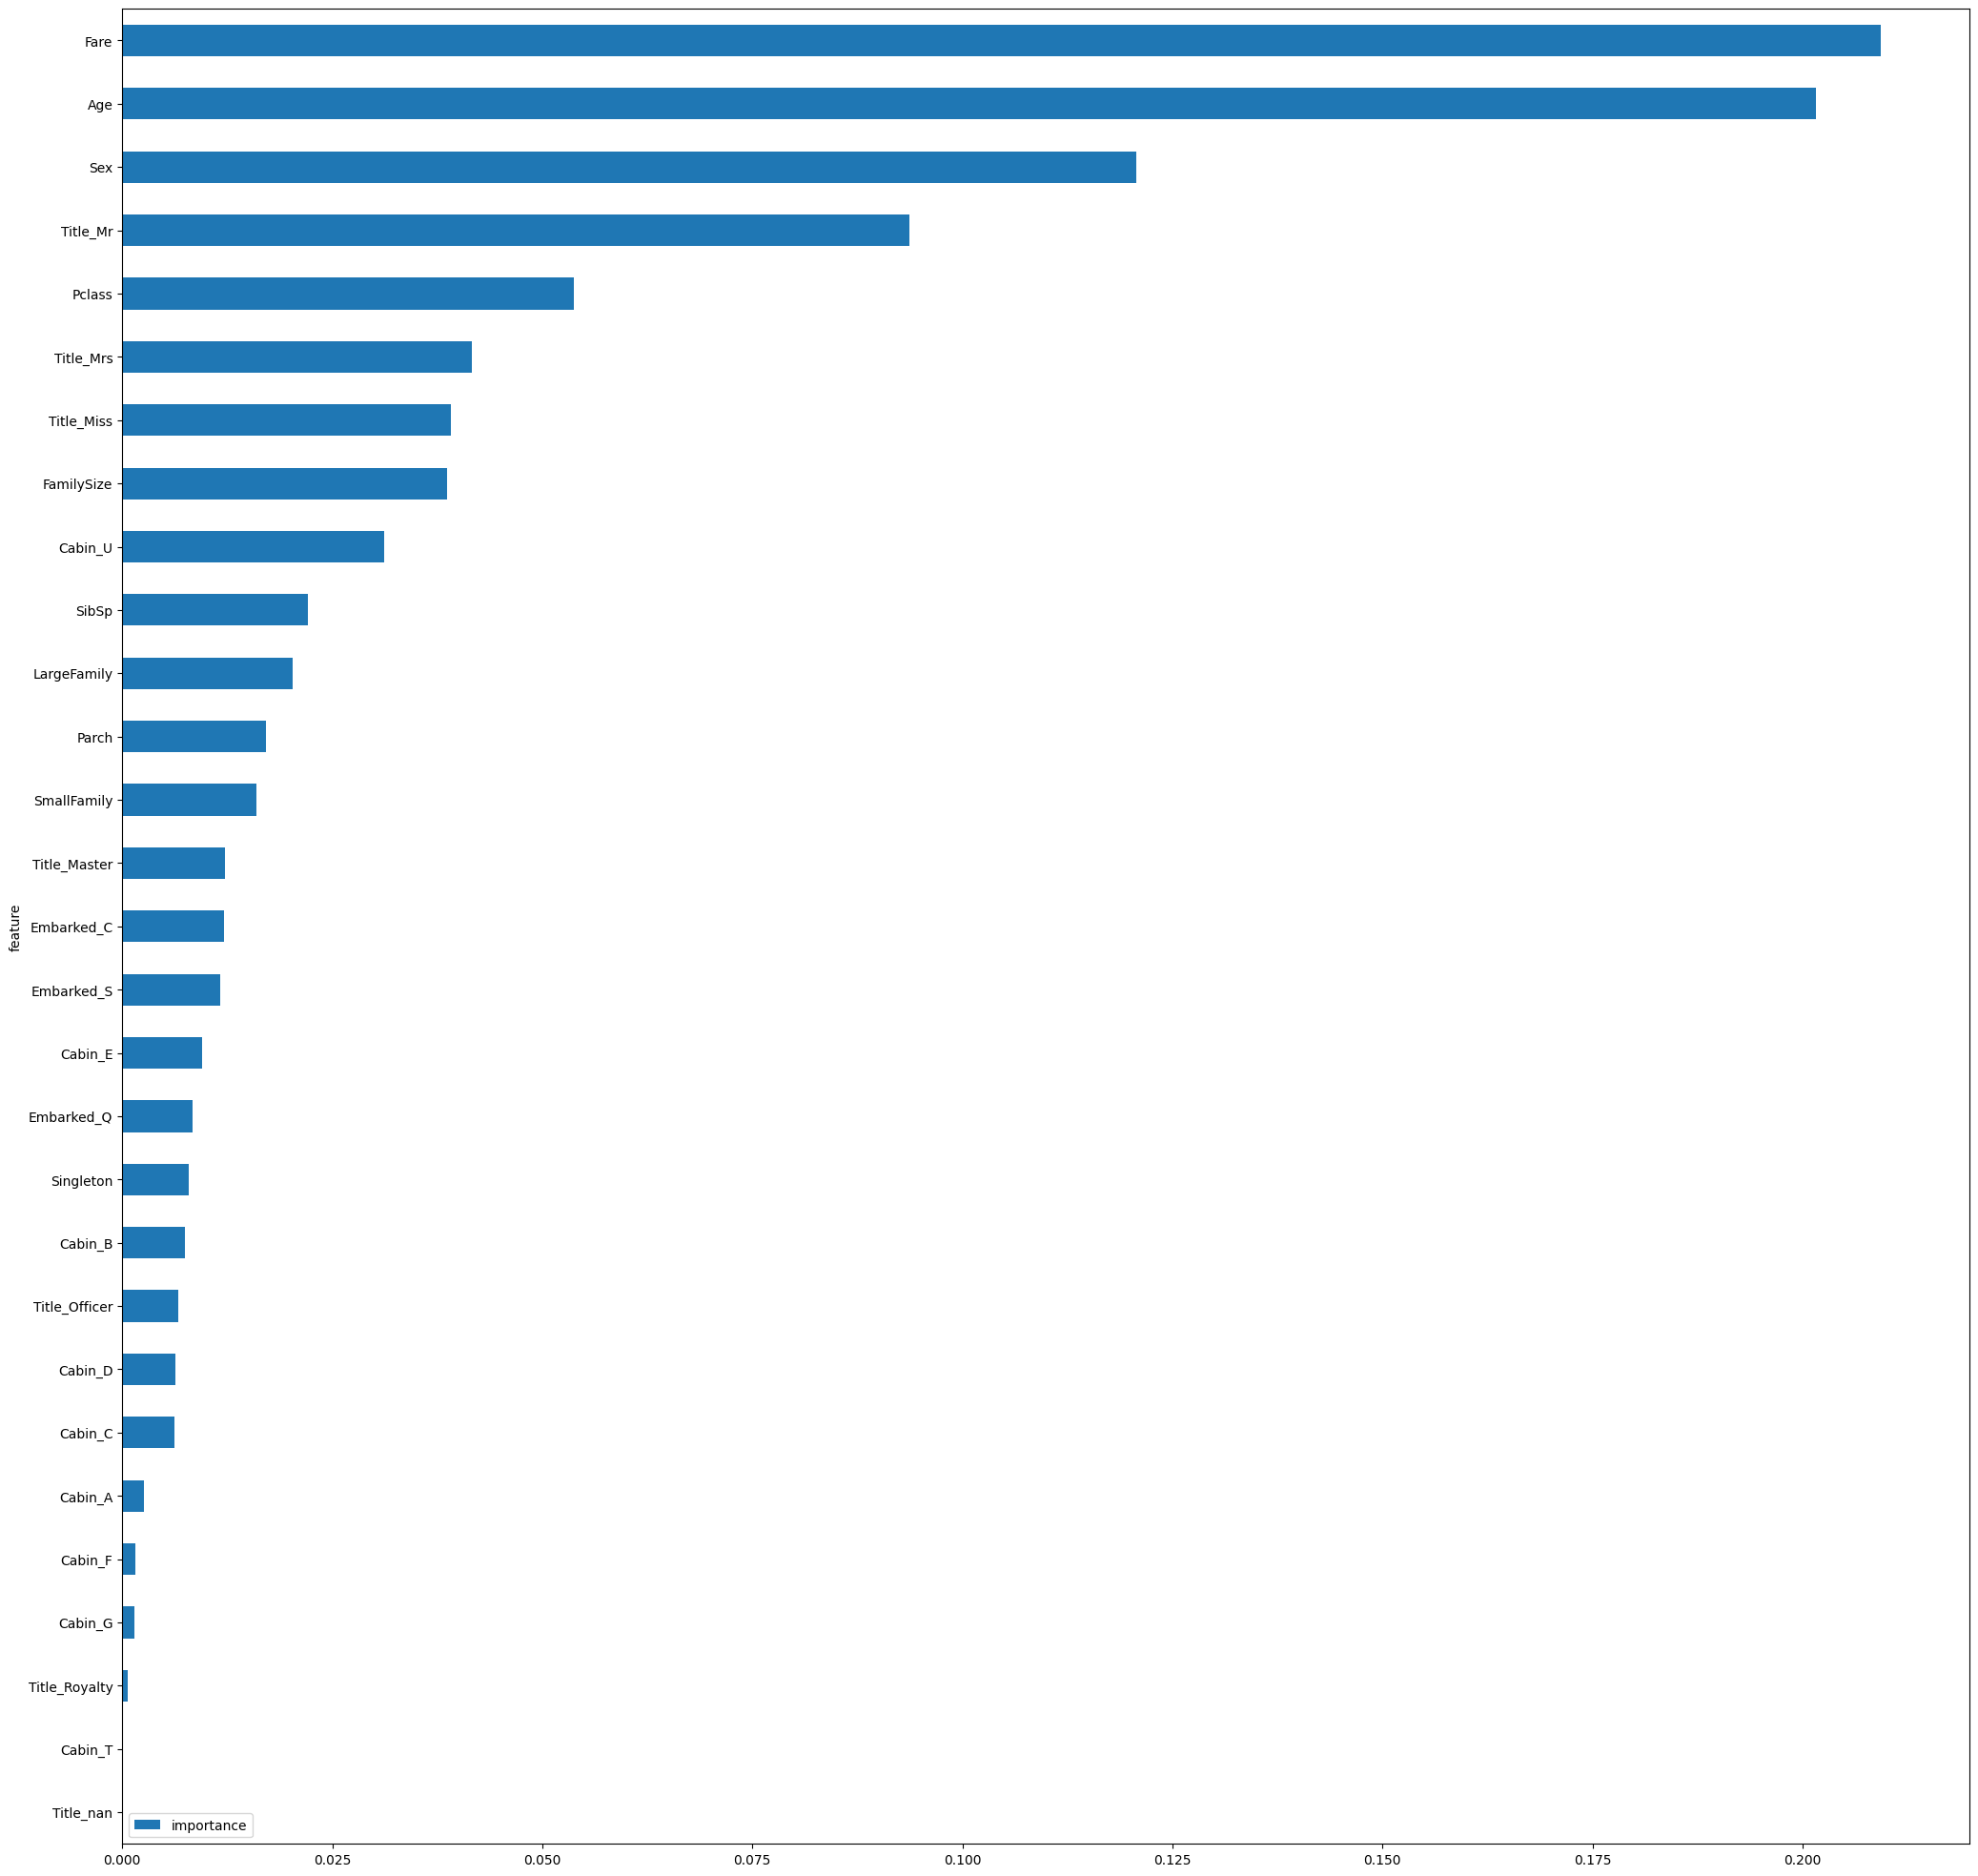

In [55]:
features.plot(kind='barh', figsize=(25, 25))

Theo sơ đồ có thể thấy, một số đặc trưng quan trọng như Title_Mr, Age, Fare, and Sex.

In [56]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
print(train_reduced.shape)

(891, 8)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [57]:
test_reduced = model.transform(test)
print(test_reduced.shape)

(418, 8)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## K-fold

In [122]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## Base Models

In [130]:
log = LogisticRegression(max_iter=5000,random_state=42)
log_cv = LogisticRegressionCV(cv=5,max_iter=5000,random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

models = [log,log_cv,rf,gb]

In [131]:
for model in models:
    print('Cross-validation of: {0}'.format(model))
    score = cross_val_score(clf, train, targets, cv=k_fold, n_jobs=1, scoring='accuracy')
    print("Score of Model:",round(np.mean(score)*100,2))

Cross-validation of: LogisticRegression(max_iter=5000, random_state=42)
Score of Model: 80.24
Cross-validation of: LogisticRegressionCV(cv=5, max_iter=5000, random_state=42)
Score of Model: 80.25
Cross-validation of: RandomForestClassifier(random_state=42)
Score of Model: 80.25
Cross-validation of: GradientBoostingClassifier(random_state=42)
Score of Model: 80.36


In [132]:
clf1 = LogisticRegression(max_iter=5000,random_state=42)
clf1.fit(train_reduced,targets)
prediction = clf1.predict(test_reduced)

## Tinh chỉnh siêu tham số (Hyperparameters Tunning):

In [133]:
from sklearn.model_selection import GridSearchCV

In [134]:
param_grid_valid = [
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'], 
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'max_iter': [5000] # Tăng max_iter để đảm bảo hội tụ
    },
    # Cấu hình 2: Điều chuẩn hóa L2 (Phổ biến và an toàn hơn)
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear', 'saga'], 
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'max_iter': [5000]
    }
]

clft = GridSearchCV(log,param_grid= param_grid_valid,cv=k_fold,verbose=True,n_jobs=-1)
clft

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=LogisticRegression(max_iter=5000, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [5000], 'penalty': ['l1'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [5000], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'liblinear', 'saga']}],
             verbose=True)

### Tìm siêu tham số tốt nhất cho mô hình

In [135]:
best_clf = clft.fit(train_reduced,targets)
best_clf

Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=LogisticRegression(max_iter=5000, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [5000], 'penalty': ['l1'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [5000], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'liblinear', 'saga']}],
             verbose=True)

In [136]:
print(f'Accuracy - : {best_clf.score(train_reduced,targets):.3f}')

Accuracy - : 0.818


## Sử dụng mô hình sau khi điều chỉnh siêu tham số

In [137]:
final_model = best_clf.best_estimator_

In [138]:
score = compute_score(clf=final_model,X=train_reduced,y=targets,scoring='accuracy')
print("Score of Model:",round(np.mean(score)*100,2))

Score of Model: 81.03


In [139]:
final_model.fit(train_reduced,targets)
prediction = final_model.predict(test_reduced)

## Tạo file Submission để up lên Kaggle

In [140]:
test_data = pd.read_csv('../data/test.csv')

In [141]:
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'], 
    'Survived': prediction
})
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv("../Submit/Submission.csv",index=False,header=True)